In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import itertools
import matplotlib.pyplot as plt

import sampler
import datasets
from earlystopping import EarlyStopping

from sklearn.metrics import accuracy_score, recall_score
from torch.autograd  import  Function

# Acoustic Branch

Inputs for acoustic branch will be N x 40 where N [1,33]  
Time step: (2, 10) (seconds?)  
N: relative duration after feature extraction

In [2]:
class AcousticNet(nn.Module):
    def __init__(self, num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2):
        super(AcousticNet, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.conv1 = nn.Conv1d(in_channels=40, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv2 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv3 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv4 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.convs = [self.conv1, self.conv2, self.conv3, self.conv4]
        self.max_pool = nn.MaxPool1d(kernel_size = 2)
        self.relu = nn.ReLU()
        
        self.gru = nn.GRU(input_size=conv_width,hidden_size=32,num_layers=num_gru_layers) # 19 is hardcoded
        self.mean_pool = nn.AvgPool1d(kernel_size=2)
        
    def forward(self, x):
        x = torch.transpose(x, 1, 2) 
#         print(x.shape)
        for i in range(self.num_conv_layers):
            x = self.relu(self.max_pool(self.convs[i](x)))
        x = torch.transpose(x, 1, 2) 
        x, _ = self.gru(x)
        x = torch.transpose(x, 1, 2)
        x = F.adaptive_avg_pool1d(x,1)[:, :, -1]
#         x = self.mean_pool(x)
        return x

In [3]:
# Test dummy input
net = AcousticNet(num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2)
batch_size = 8
n_acoustic_channels = 40
duration_acoustic = 1232
test_vec = torch.randn(batch_size, duration_acoustic, n_acoustic_channels) # samples x features (or channels) x N (relative duration)
output = net(test_vec)
print(f'Shape of output: {output.shape}')
# assert output.shape[-1] == 16

Shape of output: torch.Size([8, 32])


# Lexical Branch

In [4]:
# implement GRU (or transformer)
class LexicalNet(nn.Module):
    def __init__(self, num_gru_layers = 2):
        super(LexicalNet, self).__init__()
        # implement GRU (or transformer)
        self.gru = nn.GRU(input_size=768,hidden_size=32,num_layers=num_gru_layers)
        self.mean_pool = nn.AvgPool1d(kernel_size=2) 
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x, _ = self.gru(x)
#         x = self.mean_pool(x)
        x = self.flatten(x)
#         print(x.shape)
        return x

In [5]:
# Test dummy input
net = LexicalNet(num_gru_layers = 2)
batch_size = 8
test_vec = torch.randn(batch_size, 1, 768)
output = net(test_vec)
# assert output.shape[-1] == 16

# Master branch

In [6]:
# class GRL(Function):
#     @staticmethod
#     def forward(self,x):
#         return x
#     @staticmethod
#     def backward(self,grad_output):
#         grad_input = grad_output.neg()
#         return grad_input

In [7]:
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None
    
class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [8]:
class MasterNet(nn.Module):
    def __init__(self, acoustic_modality = True, lexical_modality = True, visual_modality = False,
                 num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2,
                 num_dense_layers = 1, dense_layer_width = 32, grl_lambda = .3):
        super(MasterNet, self).__init__()
        
        self.acoustic_modality = acoustic_modality
        self.lexical_modality = lexical_modality
        self.visual_modality = visual_modality
        
        self.acoustic_model = AcousticNet(num_conv_layers = num_conv_layers, kernel_size = kernel_size, 
                                     conv_width = conv_width, num_gru_layers = num_gru_layers)
        self.lexical_model = LexicalNet(num_gru_layers = 2)
        
        # emotion classifier
#         self.dense1_emo = nn.Linear()
#         self.dense2_emo = nn.Linear()
        
        width = 0 # width of the FC layers
        if self.acoustic_modality:
            width += 32
        if self.visual_modality:
            width += 0 # to implement
        if self.lexical_modality:
            width += 32
            
        self.fc_1 = nn.Linear(width, dense_layer_width)
        self.fc_2 = nn.Linear(dense_layer_width, 3)
        self.softmax = nn.Softmax(dim=1)

        self.relu = nn.ReLU()
#         # To implement   
#         if num_dense_layers == 2:
#             self.fc = nn.Sequential()
#             self.linear_1 = nn.Linear(width, dense_layer_width)
#         else:
#             self.fc = 
        
        # confound classifier -- to implement
        self.grl = GradientReversal(lambda_ = grl_lambda)
        self.dense_conv = nn.Linear(width, 2)
#         self.dense2_con = None
        
        
    def forward_a(self, x_a):
        x = x_a
        x = self.acoustic_model(x)
        return x
    
    def forward_l(self, x_l):
        x = torch.unsqueeze(x_l, dim = 1)
        x = self.lexical_model(x)
        return x
    
    def forward_v(self, x_v):
        x = x_v
        return x
    
    def encoder(self, x_v, x_a, x_l):
        if self.visual_modality:
            x_v = self.forward_v(x_v)
        if self.acoustic_modality:
            x_a = self.forward_a(x_a)
        if self.lexical_modality:
            x_l = self.forward_l(x_l)
        
        if self.visual_modality:
            if self.acoustic_modality:
                if self.lexical_modality:
                    x = torch.cat((x_v, x_a, x_l), 1)
                else:
                    x = torch.cat((x_v, x_a), 1)
            else:
                if self.lexical_modality:
                    x = torch.cat((x_v, x_l), 1)
                else:
                    x = x_v
        else:
            if self.acoustic_modality:
                if self.lexical_modality:
                    x = torch.cat((x_a, x_l), 1)
                else:
                    x = x_a
            else:
                x = x_l
        return x

    def confound_model(self, x):
#         x = self.grl.apply(x)
        x = self.grl(x)
        x = self.dense_conv(x)
        x = self.softmax(x)
        return x
    
    # For emotion
    def recognizer(self, x):
#         print(x.shape)
        x = self.relu(self.fc_1(x))
        x = self.fc_2(x)
        x = self.softmax(x)
        return x
    
    def forward(self, x_v, x_a, x_l):
        x = self.encoder(x_v, x_a, x_l)
        emotion_output = self.recognizer(x)
        confound_output = self.confound_model(x)
        
        return emotion_output, confound_output

In [9]:
# Test dummy input
net = MasterNet()
batch_size = 8
n_acoustic_channels = 40
duration_acoustic = 1232
acoustic_features = torch.randn(batch_size, duration_acoustic, n_acoustic_channels) # samples x features (or channels) x N (relative duration)
# lexical_features = torch.randn(batch_size, 1, 300)
lexical_features = torch.randn(batch_size, 768)
visual_features = None
emotion_output, stress_output = net(visual_features, acoustic_features, lexical_features)
print(f'Shape of emotion output: {emotion_output.shape}')
print(f'Shape of stress output: {stress_output.shape}')
print(emotion_output)
print(stress_output)
# assert output.shape[-1] == 16

Shape of emotion output: torch.Size([8, 3])
Shape of stress output: torch.Size([8, 2])
tensor([[0.3390, 0.3572, 0.3038],
        [0.3378, 0.3475, 0.3147],
        [0.3361, 0.3413, 0.3226],
        [0.3340, 0.3444, 0.3216],
        [0.3343, 0.3456, 0.3201],
        [0.3319, 0.3386, 0.3295],
        [0.3379, 0.3409, 0.3212],
        [0.3427, 0.3499, 0.3074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163],
        [0.4901, 0.5099],
        [0.4634, 0.5366],
        [0.4529, 0.5471],
        [0.4420, 0.5580],
        [0.4342, 0.5658],
        [0.4193, 0.5807],
        [0.4254, 0.5746]], grad_fn=<SoftmaxBackward>)


In [10]:
# Use specific GPU
def get_device():
    if torch.cuda.is_available():  
        dev = "cuda:0" 
    else:  
        dev = "cpu"  
    return torch.device(dev)
device = get_device()

In [11]:
def train_one_folder(model, folder = 0, epochs = 1, verbose = False, learning_rate = 1e-4, patience = 5):
    # Use specific GPU
    device = get_device()

    # Dataloaders    
    train_dataset_file_path = '../dataset/IEMOCAP/' + str(folder) + '/train.csv'
    train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
    test_dataset_file_path = '../dataset/IEMOCAP/' + str(folder) + '/test.csv'
    test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

    # Model, optimizer and loss function
    init_weights(model)
    for param in emotion_recognizer.parameters():
        param.requires_grad = True
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.
    best_uar = 0.
    es = EarlyStopping(patience=patience)

    # Train and validate
    for epoch in range(epochs):
        if verbose:
            print('epoch: {}/{}'.format(epoch + 1, epochs))

        train_loss, train_acc = train(train_loader, model,
                                        optimizer, criterion, device)
        test_loss, test_acc, test_uar = test(test_loader, model,
                                                criterion, device)

        if verbose:
            print('train_emotion_loss: {0:.5f}'.format(train_loss['emotion_loss']),
                  'train_emotion_acc: {0:.3f}'.format(train_acc['emotion_acc']),
                  'train_confound_loss: {0:.5f}'.format(train_loss['confound_loss']),
                  'train_confound_acc: {0:.3f}'.format(train_acc['confound_acc']),
                  'test_emotion_loss: {0:.5f}'.format(test_loss['emotion_loss']),
                  'test_emotion_acc: {0:.3f}'.format(test_acc['emotion_acc']),
                  'test_confound_loss: {0:.5f}'.format(test_loss['confound_loss']),
                  'test_confound_acc: {0:.3f}'.format(test_acc['confound_acc']),
                  'test_emotion_uar: {0:.3f}'.format(test_uar['emotion_uar']),
                  'test_confound_uar: {0:.3f}'.format(test_uar['confound_uar']))

        lr_schedule.step(test_loss['loss'])

#         os.makedirs(os.path.join(opt.logger_path, opt.source_domain), exist_ok=True)

#         model_file_name = os.path.join(opt.logger_path, opt.source_domain, 'checkpoint.pth.tar')
#         state = {'epoch': epoch+1, 'emotion_recognizer': emotion_recognizer.state_dict(), 'opt': opt}
#         torch.save(state, model_file_name)

        if test_acc['emotion_acc'] > best_acc:
#             model_file_name = os.path.join(opt.logger_path, opt.source_domain, 'model.pth.tar')
#             torch.save(state, model_file_name)

            best_acc = test_acc['emotion_acc']

        if test_uar['emotion_uar'] > best_uar:
            best_uar = test_uar['emotion_uar']

        if es.step(test_loss['emotion_loss']):
            break

    return best_acc, best_uar

In [12]:
def train_baseline(train_loader, model, optimizer, criterion, device, verbose = False):
    model.train()

    running_loss = 0.
    running_acc = 0.

    groundtruth = []
    prediction = []

    for i, train_data in enumerate(train_loader):
        visual_features, _, acoustic_features, _, lexical_features, _, _, a_labels, _, _ = train_data # UPDATE

        visual_features = visual_features.to(device)
        acoustic_features = acoustic_features.to(device)
        lexical_features = lexical_features.to(device)

        labels = a_labels.to(device)

        optimizer.zero_grad()
        
        emotion_output, stress_output = model(visual_features, acoustic_features, lexical_features)

        emotion_loss = criterion(emotion_output, labels)
#         stress_loss = criterion(stress_output, stress_labels)

        emotion_loss.backward()
#         stress_loss.backward()
        
        optimizer.step() # do we need two optimizers?
        
        running_loss += emotion_loss.item()

        groundtruth.append(labels.tolist())
        predictions = emotion_output.argmax(dim=1, keepdim=True)
        prediction.append(predictions.view_as(labels).tolist())

        if verbose and i > 0 and int(len(train_loader) / 10) > 0 and i % (int(len(train_loader) / 10)) == 0:
            print('.', flush=True, end='')
            
    train_loss = running_loss / len(train_loader)

    groundtruth = list(itertools.chain.from_iterable(groundtruth))
    prediction = list(itertools.chain.from_iterable(prediction))

    train_acc = accuracy_score(prediction, groundtruth)

    return train_loss, train_acc

When we train baseline, the loss from the confound is NOT included in backpropagation, only the loss from the emotion task. 

In [23]:
def train(train_loader, model, optimizer, criterion, device, verbose = False, emotion_dimension = 'arousal', baseline = False):
    model.train()

    running_loss = 0.
    emotion_running_loss = 0.
    confound_running_loss = 0.
    running_acc = 0.

    emotion_groundtruth = []
    emotion_prediction = []
    
    confound_groundtruth = []
    confound_prediction = []

    for i, train_data in enumerate(train_loader):
        visual_features, _, acoustic_features, _, lexical_features, _, v_labels, a_labels, d_labels, s_labels, _ = train_data # UPDATE

        visual_features = visual_features.to(device)
        acoustic_features = acoustic_features.to(device)
        lexical_features = lexical_features.to(device)

        if emotion_dimension == 'arousal':
            emotion_labels = a_labels.to(device)
        elif emotion_dimension == 'valence':
            emotion_labels = v_labels.to(device)
        else:
            print("Invalid emotion dimension")
            return
        confound_labels = s_labels.to(device)

        optimizer.zero_grad()
        
        emotion_predictions, confound_predictions = model(visual_features, acoustic_features, lexical_features)
        
        emotion_loss = criterion(emotion_predictions, emotion_labels)
        confound_loss = criterion(confound_predictions, confound_labels)
        loss = emotion_loss + confound_loss
        if baseline == True:
            loss = emotion_loss
        else:
            loss = emotion_loss + confound_loss
        
        loss.backward()

        optimizer.step() # do we need two optimizers?
        
        emotion_running_loss += emotion_loss.item()
        confound_running_loss += confound_loss.item()
        running_loss += emotion_running_loss + confound_running_loss

        emotion_groundtruth.append(emotion_labels.tolist())
        emotion_predictions = emotion_predictions.argmax(dim=1, keepdim=True)
        emotion_prediction.append(emotion_predictions.view_as(emotion_labels).tolist())
        
        confound_groundtruth.append(confound_labels.tolist())
        confound_predictions = confound_predictions.argmax(dim=1, keepdim=True)
        confound_prediction.append(confound_predictions.view_as(confound_labels).tolist())

        if verbose and i > 0 and int(len(train_loader) / 10) > 0 and i % (int(len(train_loader) / 10)) == 0:
            print('.', flush=True, end='')
        
    emotion_loss = emotion_running_loss / len(train_loader)
    confound_loss = confound_running_loss / len(train_loader)
    loss = running_loss / len(train_loader)
    train_loss = {'emotion_loss': emotion_loss,
                  'confound_loss': confound_loss,
                  'loss': loss
                 }

    emotion_groundtruth = list(itertools.chain.from_iterable(emotion_groundtruth))
    emotion_prediction = list(itertools.chain.from_iterable(emotion_prediction))
    
    confound_groundtruth = list(itertools.chain.from_iterable(confound_groundtruth))
    confound_prediction = list(itertools.chain.from_iterable(confound_prediction))

    emotion_acc = accuracy_score(emotion_prediction, emotion_groundtruth)
    confound_acc = accuracy_score(confound_prediction, confound_groundtruth)
    avg_acc = (emotion_acc + confound_acc) / 2
    
    train_acc = {'emotion_acc': emotion_acc,
                  'confound_acc': confound_acc
                }

    return train_loss, train_acc

In [14]:
def test_baseline(test_loader, model, criterion, device):
    model.eval()

    running_loss = 0.
    running_acc = 0.

    with torch.no_grad():
        groundtruth = []
        prediction = []

        for i, test_data in enumerate(test_loader):
            visual_features, _, acoustic_features, _, lexical_features, _, v_labels, a_labels, d_labels, _ = test_data # UPDATE

            visual_features = visual_features.to(device)
            acoustic_features = acoustic_features.to(device)
            lexical_features = lexical_features.to(device)

            labels = a_labels.to(device)

            emotion_predictions, confound_predictions = model(visual_features, acoustic_features, lexical_features)
            loss = criterion(emotion_predictions, labels)

            running_loss += loss.item()

            groundtruth.append(labels.tolist())
            emotion_predictions = emotion_predictions.argmax(dim=1, keepdim=True)
            prediction.append(emotion_predictions.view_as(labels).tolist())

        test_loss = running_loss / len(test_loader)

        groundtruth = list(itertools.chain.from_iterable(groundtruth))
        prediction = list(itertools.chain.from_iterable(prediction))

        test_acc = accuracy_score(prediction, groundtruth)
        test_uar = recall_score(prediction, groundtruth, average='macro')

        return test_loss, test_acc, test_uar

In [15]:
def test(test_loader, model, criterion, device, emotion_dimension = 'arousal'):
    model.eval()

    running_loss = 0.
    emotion_running_loss = 0.
    confound_running_loss = 0.
    running_acc = 0.

    with torch.no_grad():
        emotion_groundtruth = []
        emotion_prediction = []

        confound_groundtruth = []
        confound_prediction = []

        for i, test_data in enumerate(test_loader):
            visual_features, _, acoustic_features, _, lexical_features, _, v_labels, a_labels, d_labels, s_labels, _ = test_data # UPDATE

            visual_features = visual_features.to(device)
            acoustic_features = acoustic_features.to(device)
            lexical_features = lexical_features.to(device)
            
            if emotion_dimension == 'arousal':
                emotion_labels = a_labels.to(device)
            elif emotion_dimension == 'valence':
                emotion_labels = v_labels.to(device)
            else:
                print("Invalid emotion dimension")
                return
            confound_labels = s_labels.to(device)

            emotion_predictions, confound_predictions = model(visual_features, acoustic_features, lexical_features)
            
            emotion_loss = criterion(emotion_predictions, emotion_labels)
            confound_loss = criterion(confound_predictions, confound_labels)
            loss = emotion_loss + confound_loss

            emotion_running_loss += emotion_loss.item()
            confound_running_loss += confound_loss.item()
            running_loss += emotion_running_loss + confound_running_loss

            emotion_groundtruth.append(emotion_labels.tolist())
            emotion_predictions = emotion_predictions.argmax(dim=1, keepdim=True)
            emotion_prediction.append(emotion_predictions.view_as(emotion_labels).tolist())

            confound_groundtruth.append(confound_labels.tolist())
            confound_predictions = confound_predictions.argmax(dim=1, keepdim=True)
            confound_prediction.append(confound_predictions.view_as(confound_labels).tolist())

        emotion_loss = emotion_running_loss / len(train_loader)
        confound_loss = confound_running_loss / len(train_loader)
        loss = running_loss / len(train_loader)
        test_loss = {'emotion_loss': emotion_loss,
                     'confound_loss': confound_loss,
                     'loss': loss
                    }

        emotion_groundtruth = list(itertools.chain.from_iterable(emotion_groundtruth))
        emotion_prediction = list(itertools.chain.from_iterable(emotion_prediction))

        confound_groundtruth = list(itertools.chain.from_iterable(confound_groundtruth))
        confound_prediction = list(itertools.chain.from_iterable(confound_prediction))

        emotion_acc = accuracy_score(emotion_prediction, emotion_groundtruth)
        confound_acc = accuracy_score(confound_prediction, confound_groundtruth)
        avg_acc = (emotion_acc + confound_acc) / 2
        test_acc = {'emotion_acc': emotion_acc,
                    'confound_acc': confound_acc
                   }
        
        emotion_uar = recall_score(emotion_prediction, emotion_groundtruth, average='macro')
        confound_uar = recall_score(confound_prediction, confound_groundtruth, average='macro')

        test_uar = {'emotion_uar': emotion_uar,
                    'confound_uar': confound_uar
                   }

        return test_loss, test_acc, test_uar

In [16]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

## Train + Test for Valence and Arousal with adversarial learning

### Audio and Lexical w/ Adversarial for Valence

In [25]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/3
Train loss: {'emotion_loss': 1.0262766043847638, 'confound_loss': 0.6968713596405223, 'loss': 897.7760060264327}
Train acc: {'emotion_acc': 0.5085158150851582, 'confound_acc': 0.5141119221411192}
Epoch 1/3
Train loss: {'emotion_loss': 0.9685588047662134, 'confound_loss': 0.69297020433014, 'loss': 861.1841793767093}
Train acc: {'emotion_acc': 0.57007299270073, 'confound_acc': 0.5110705596107056}
Epoch 2/3
Train loss: {'emotion_loss': 0.9001411217543865, 'confound_loss': 0.6904657095206851, 'loss': 821.7689868371194}
Train acc: {'emotion_acc': 0.6491484184914842, 'confound_acc': 0.5115571776155717}


In [26]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.19944935961688076, 'confound_loss': 0.1478692471749124, 'loss': 40.20029201088944}
Test acc: {'emotion_acc': 0.6421110500274876, 'confound_acc': 0.5838372732270478}
Test uar: {'emotion_uar': 0.4130423093725846, 'confound_uar': 0.6667355371900827}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


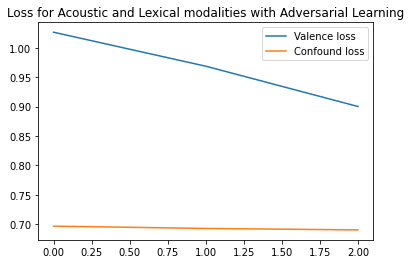

In [27]:
plt.title('Loss for Acoustic and Lexical modalities with Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Audio and Lexical w/ Adversarial for Arousal

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Acoustic and Lexical modalities with Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/ Adversarial for Valence

In [21]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/30
Train loss: {'emotion_loss': 1.022733929730111, 'confound_loss': 0.6960138081344649, 'loss': 894.0060584385687}
Train acc: {'emotion_acc': 0.5222627737226277, 'confound_acc': 0.505352798053528}
Epoch 1/30
Train loss: {'emotion_loss': 1.0005389876982582, 'confound_loss': 0.709725619464069, 'loss': 879.2162220832323}
Train acc: {'emotion_acc': 0.545985401459854, 'confound_acc': 0.49330900243309}
Epoch 2/30
Train loss: {'emotion_loss': 0.9972552922101336, 'confound_loss': 0.6954831711744984, 'loss': 869.1035517824647}
Train acc: {'emotion_acc': 0.5479318734793187, 'confound_acc': 0.5052311435523115}
Epoch 3/30
Train loss: {'emotion_loss': 0.9924549764812225, 'confound_loss': 0.6980505176323397, 'loss': 867.7392715406442}
Train acc: {'emotion_acc': 0.5525547445255474, 'confound_acc': 0.5030413625304136}
Epoch 4/30
Train loss: {'emotion_loss': 0.9938927118300463, 'confound_loss': 0.696831961434175, 'loss': 870.4618173838821}
Train acc: {'emotion_acc': 0.5502433090024331, 'confoun

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Acoustic modalities with Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/ Adversarial for Arousal

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Acoustic modality with Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/ Adversarial for Valence

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Lexical modality with Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/ Adversarial for Arousal

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal')
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Lexical modality with Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

## Train + Test for Valence and Arousal without adversarial learning

### Audio and Lexical w/o Adversarial for Valence

In [25]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/3
Train loss: {'emotion_loss': 1.0262766043847638, 'confound_loss': 0.6968713596405223, 'loss': 897.7760060264327}
Train acc: {'emotion_acc': 0.5085158150851582, 'confound_acc': 0.5141119221411192}
Epoch 1/3
Train loss: {'emotion_loss': 0.9685588047662134, 'confound_loss': 0.69297020433014, 'loss': 861.1841793767093}
Train acc: {'emotion_acc': 0.57007299270073, 'confound_acc': 0.5110705596107056}
Epoch 2/3
Train loss: {'emotion_loss': 0.9001411217543865, 'confound_loss': 0.6904657095206851, 'loss': 821.7689868371194}
Train acc: {'emotion_acc': 0.6491484184914842, 'confound_acc': 0.5115571776155717}


In [26]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

Test loss: {'emotion_loss': 0.19944935961688076, 'confound_loss': 0.1478692471749124, 'loss': 40.20029201088944}
Test acc: {'emotion_acc': 0.6421110500274876, 'confound_acc': 0.5838372732270478}
Test uar: {'emotion_uar': 0.4130423093725846, 'confound_uar': 0.6667355371900827}


/home/brandon/src/stressed_emotion/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


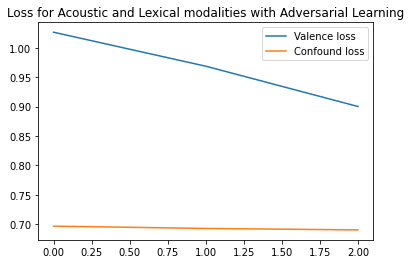

In [27]:
plt.title('Loss for Acoustic and Lexical modalities without Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Audio and Lexical w/ Adversarial for Arousal

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Acoustic and Lexical modalities without Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/ Adversarial for Valence

In [21]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

Epoch 0/30
Train loss: {'emotion_loss': 1.022733929730111, 'confound_loss': 0.6960138081344649, 'loss': 894.0060584385687}
Train acc: {'emotion_acc': 0.5222627737226277, 'confound_acc': 0.505352798053528}
Epoch 1/30
Train loss: {'emotion_loss': 1.0005389876982582, 'confound_loss': 0.709725619464069, 'loss': 879.2162220832323}
Train acc: {'emotion_acc': 0.545985401459854, 'confound_acc': 0.49330900243309}
Epoch 2/30
Train loss: {'emotion_loss': 0.9972552922101336, 'confound_loss': 0.6954831711744984, 'loss': 869.1035517824647}
Train acc: {'emotion_acc': 0.5479318734793187, 'confound_acc': 0.5052311435523115}
Epoch 3/30
Train loss: {'emotion_loss': 0.9924549764812225, 'confound_loss': 0.6980505176323397, 'loss': 867.7392715406442}
Train acc: {'emotion_acc': 0.5525547445255474, 'confound_acc': 0.5030413625304136}
Epoch 4/30
Train loss: {'emotion_loss': 0.9938927118300463, 'confound_loss': 0.696831961434175, 'loss': 870.4618173838821}
Train acc: {'emotion_acc': 0.5502433090024331, 'confoun

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Acoustic modalities with Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Acoustic w/ Adversarial for Arousal

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = False, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Acoustic modality without Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/ Adversarial for Valence

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'valence', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'valence')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Lexical modality without Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Valence loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

### Lexical w/ Adversarial for Arousal

In [ ]:
emotion_recognizer = MasterNet(acoustic_modality = False, lexical_modality = True, visual_modality = False, grl_lambda = .8)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

emotion_loss = []
confound_loss = []
loss = []
epochs = 30
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device, emotion_dimension = 'arousal', baseline=True)
    emotion_loss.append(train_loss['emotion_loss'])
    confound_loss.append(train_loss['confound_loss'])
    loss.append(train_loss['loss'])
    print(f'Train loss: {train_loss}')
    print(f'Train acc: {train_acc}')

In [ ]:
test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device, emotion_dimension = 'arousal')
print(f'Test loss: {test_loss}')
print(f'Test acc: {test_acc}')
print(f'Test uar: {test_uar}')

In [ ]:
plt.title('Loss for Lexical modality without Adversarial Learning')
plt.plot(range(epochs), emotion_loss, label = 'Arousal loss')
plt.plot(range(epochs), confound_loss, label = 'Confound loss')
plt.legend()

## Train all folders

In [ ]:
acc = []
uar = []

In [ ]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 0, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

In [ ]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 1, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

In [ ]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 2, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

In [ ]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 3, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

In [ ]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 4, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(5),acc)

In [ ]:
plt.bar(range(5),uar)

In [ ]:
print(acc)
print(uar)

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame([acc,uar]).T

In [ ]:
np.average(acc)

In [ ]:
np.average(uar)